In [1]:
from preproc_utils import *
from Get_PSSM import *
from Get_dataset import *
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,f1_score

chebi = pd.read_table('/Users/suhancho/data/Uniprot_metalbinding_challenge/POS_TRAIN_FULL.tsv')
inpath = '/Users/suhancho/data/Uniprot_metalbinding_challenge/chebi/'
bind_tsv_list = [inpath + f for f in os.listdir(inpath)]
pssm_path = '/Users/suhancho/data/Uniprot_metalbinding_challenge/PSSM/'
pssm_files = [pssm_path+f for f in os.listdir(pssm_path)]
bindlist = pd.concat([pd.read_table(f) for f in bind_tsv_list])
low_labels = [l.replace(' ','') for l in bindlist.Name.value_counts().index[bindlist.Name.value_counts()<1000]]

In [2]:
bindlist['Name'] = pd.Categorical(bindlist.Name)
bindlist['Target'] = bindlist.Name.cat.codes

In [3]:
def calculate_window(start,num_inspections,bs_df):
    train_dat=[]
    for i,pssm in tqdm(enumerate(pssm_files[start:num_inspections])):
        bs = get_binding_site_multi(bs_df,pssm.split('/')[-1].split('.')[0])
        gt = get_dataset_padded_multi(get_processed_pssm(pssm),bs)
        for g in gt : 
            train_dat.append([g[0].values.tolist(),g[1]])
            
    return(train_dat)

In [4]:
def preproc_data(windowdata):
    train_X = [dat[0] for dat in windowdata]
    train_Y = [dat[1] for dat in windowdata]
    print('Size of dataset : '+str(len(train_X)))
    return(train_X,train_Y)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
def check_windowdata(traindata):
    sns.histplot([len(t) for t in traindata])
    plt.show()

In [6]:
def filter_traindata(Xdata,Ydata):
    train_X_filtered = [Xdata[i] for i in range(len(Xdata)) if len(Xdata[i])==9]
    train_Y_filtered = [Ydata[i] for i in range(len(Xdata)) if len(Xdata[i])==9]
    return(train_X_filtered,train_Y_filtered)  

In [7]:
from itertools import chain
def flatten_Xdata(filtered_X):
    flatten_trainX = [list(chain.from_iterable(lst)) for lst in filtered_X]
    return(flatten_trainX)

In [8]:
def get_MLmetrics_multilabel(testset_y,testset_X,classifier,ion_name):
    predicty = list(gs.predict(testset_X))
    ytest = label_binarize(testset_y, classes=list(set(testy)))
    ypreds = label_binarize(predicty, classes=list(set(testy)))
    auc = roc_auc_score(ytest, ypreds,average='micro',multi_class='ovo')
    acc = accuracy_score(testset_y,predicty)
    f1 = f1_score(testset_y,predicty,average='micro')
    recall = recall_score(testset_y,predicty,average='micro')
    prec = precision_score(testset_y,predicty,average = 'micro')    
    auc_mac = roc_auc_score(ytest, ypreds,average='macro',multi_class='ovo')
    acc = accuracy_score(testset_y,predicty)
    f1_mac = f1_score(testset_y,predicty,average='macro')
    recall_mac = recall_score(testset_y,predicty,average='macro')
    prec_mac = precision_score(testset_y,predicty,average = 'macro')    
    print('ION = '+ion_name)
    print('Accuracy = '+str(round(acc,2)))

    print('AUC ( Micro ) = '+str(round(auc,2)))
    print('Recall ( Micro ) = '+str(round(recall,2)))
    print('F1 ( Micro ) = '+str(round(f1,2)))
    print('Precision ( Micro ) = '+str(round(prec,2)))
    print('AUC ( Macro ) = '+str(round(auc_mac,2)))
    print('Recall ( Macro ) = '+str(round(recall_mac,2)))
    print('F1 ( Macro ) = '+str(round(f1_mac,2)))
    print('Precision ( Macro ) = '+str(round(prec_mac,2)))
    return(acc,auc,recall,f1,prec,auc_mac,recall_mac,f1_mac,prec_mac)
    

In [9]:
def balance_classes(traindata,fold):
    label1 = [traindata[i] for i in range(len(traindata)) if traindata[i][1]==1]
    label0 = [traindata[i] for i in range(len(traindata)) if traindata[i][1]==0]
    balanced0 = random.sample(label0,len(label1)*fold)
    return(balanced0+label1)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

10000it [04:06, 40.51it/s]


Size of dataset : 42440


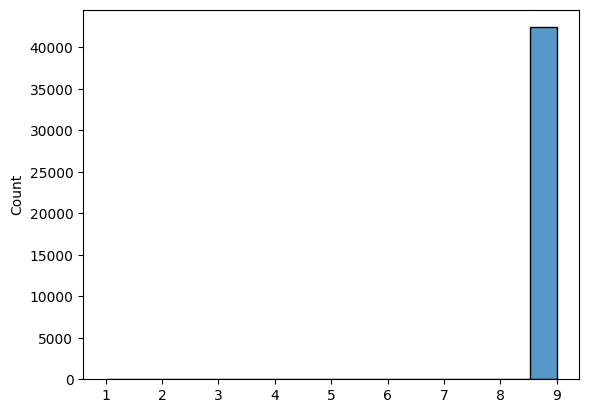

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END svc__C=0.001, svc__decision_function_shape=ovo, svc__gamma=0.001, svc__kernel=rbf;, score=0.327 total time= 1.0min
[CV 2/2] END svc__C=0.001, svc__decision_function_shape=ovo, svc__gamma=0.001, svc__kernel=rbf;, score=0.327 total time= 1.0min
[CV 1/2] END svc__C=0.001, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.327 total time= 1.0min
[CV 2/2] END svc__C=0.001, svc__decision_function_shape=ovo, svc__gamma=0.01, svc__kernel=rbf;, score=0.327 total time= 1.0min
[CV 1/2] END svc__C=0.001, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.327 total time=  58.9s
[CV 2/2] END svc__C=0.001, svc__decision_function_shape=ovo, svc__gamma=0.1, svc__kernel=rbf;, score=0.327 total time=  58.9s
[CV 1/2] END svc__C=0.001, svc__decision_function_shape=ovo, svc__gamma=1.0, svc__kernel=rbf;, score=0.327 total time= 1.1min
[CV 2/2] END svc__C=0.001, svc__decision_function_s

In [12]:
num_prot = 10000
train_dat = calculate_window(0,num_prot,bindlist)
train_X,train_Y = preproc_data(train_dat)
check_windowdata(train_X)
train_X,train_Y = filter_traindata(train_X,train_Y)
flatten_trainX = flatten_Xdata(train_X)
trainX, testX, trainy, testy = train_test_split(flatten_trainX,train_Y,test_size=0.4,shuffle = True)

X = trainX ; y = trainy

pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=9510))

# param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
# {'svc__C': param_range, 
#             'svc__kernel': ['linear'],
#             'svc__decision_function_shape':['ovo']},
param_grid = [{'svc__C': param_range, 
            'svc__gamma': param_range, 
            'svc__kernel': ['rbf'],
            'svc__decision_function_shape':['ovo']}]

gs = GridSearchCV(estimator=pipe_svc, 
                param_grid=param_grid, 
                scoring='accuracy', 
                cv=2,
                n_jobs=4,verbose=3)
gs = gs.fit(X, y)
acc,auc,recall,f1,prec,auc_mac,recall_mac,f1_mac,prec_mac = get_MLmetrics_multilabel(testy,testX,gs,'multi')